In [1]:
import os, random, glob, pickle, collections, math
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [5]:
# TRAIN_DIR = '../data/train/'
TEST_DIR = '../RFCN/JPEGImages/'
RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
CROP_MODEL = 'resnet50_DO5_FT38_DataLessNoF'
if not os.path.exists('./' + CROP_MODEL):
    os.mkdir('./' + CROP_MODEL)
CHECKPOINT_DIR = './' + CROP_MODEL + '/checkpoint/'
if not os.path.exists(CHECKPOINT_DIR):
    os.mkdir(CHECKPOINT_DIR)
LOG_DIR = './' + CROP_MODEL + '/log/'
OUTPUT_DIR = './' + CROP_MODEL + '/output/'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
CONF_THRESH = 0.8
ROWS = 224
COLS = 224
BATCHSIZE = 128
LEARNINGRATE = 1e-4
BG_THRESH_HI = 0.3
BG_THRESH_LO = 0.1
# like RCNN expand the crop by 16 pixels
p = 16

def load_img(path, bbox, target_size=None):
    img = Image.open(path)
    img = img.convert('RGB')
    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    if target_size:
        cropped = cropped.resize((target_size[1], target_size[0]))
    return cropped

def preprocess_input(x):
    #resnet50 image preprocessing
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

def get_best_model():
    files = glob.glob(CHECKPOINT_DIR+'*')
    val_losses = [float(f.split('-')[-1][:-5]) for f in files]
    index = val_losses.index(min(val_losses))
    print('Loading model from checkpoint file ' + files[index])
    model = load_model(files[index])
    return model

In [3]:
# GTbbox_df = ['image_file','crop_index','crop_class','xmin',''ymin','xmax','ymax']

file_name = 'GTbbox_df.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    GTbbox_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)       
    GTbbox_df = pd.DataFrame(columns=['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])  

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')

    for c in crop_classes:
        print(c)
        j = json.load(open('../data/BBannotations/{}.json'.format(c), 'r'))
        for l in j: 
            filename = l["filename"]
            head, image_file = os.path.split(filename)
            basename, file_extension = os.path.splitext(image_file) 
            image = Image.open(TEST_DIR+'/'+image_file)
            width_image, height_image = image.size
            for i in range(len(l["annotations"])):
                a = l["annotations"][i]
                xmin = (a["x"])
                ymin = (a["y"])
                width = (a["width"])
                height = (a["height"])
                delta_width = p/(COLS-2*p)*width
                delta_height = p/(ROWS-2*p)*height
                xmin_expand = xmin-delta_width
                ymin_expand = ymin-delta_height
                xmax_expand = xmin+width+delta_width
                ymax_expand = ymin+height+delta_height
                assert max(xmin_expand,0)<min(xmax_expand,width_image)
                assert max(ymin_expand,0)<min(ymax_expand,height_image)
                GTbbox_df.loc[len(GTbbox_df)]=[image_file,i,a["class"],max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]
                if a["class"] != c: print(GTbbox_df.tail(1))

    GTbbox_df.to_pickle(OUTPUT_DIR+file_name)    

Loading from file GTbbox_df.pickle


In [8]:
# NoFbbox_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#               'NoF_RFCN','ALB_RFCN','BET_RFCN','DOL_RFCN','LAG_RFCN','OTHER_RFCN','SHARK_RFCN','YFT_RFCN']
def IoU(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def bg_discrimination(box, gt_bboxes):
    # if BG_THRESH_LO<IoU<BG_THRESH_HI then box is bg return True
    IoUs = []
    for gt_box in gt_bboxes:
        IoUs.append(IoU(box, gt_box))
    if IoUs:
        if max(IoUs) > BG_THRESH_LO and max(IoUs) < BG_THRESH_HI:
            return True
        else:
            return False            

file_name = 'NoFbbox_df.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    NoFbbox_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)
    with open('../data/RFCN_detections/detections_RoIs_'+RFCN_MODEL+'.pkl','rb') as f:
        detections_RoIs = pickle.load(f, encoding='latin1')
    train_detections_RoIs = detections_RoIs[1000:]
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    train_files = test_files[1000:]
    assert len(train_detections_RoIs) == len(train_files)

    NoFbbox_df = pd.DataFrame(columns=['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
                                       'NoF_RFCN','ALB_RFCN','BET_RFCN','DOL_RFCN','LAG_RFCN','OTHER_RFCN','SHARK_RFCN','YFT_RFCN']) 

    for im in range(len(train_files)):
        if im%1000 == 0: print(im)
        image_file = train_files[im][:-1]+'.jpg'
        image = Image.open(TEST_DIR+image_file)
        width_image, height_image = image.size
        gt_bboxes = GTbbox_df.loc[GTbbox_df['image_file'] == image_file, ['xmin','ymin','xmax','ymax']].values

        bboxes = []
        detects_im = train_detections_RoIs[im]
        for i in range(len(detects_im)):
            if bg_discrimination(detects_im[i,:4], gt_bboxes):
                bboxes.append(detects_im[i,:]) 

        for j in range(len(bboxes)):    
            bbox = bboxes[j]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax-xmin
            height = ymax-ymin
            delta_width = p/(COLS-2*p)*width
            delta_height = p/(ROWS-2*p)*height
            xmin_expand = xmin-delta_width
            ymin_expand = ymin-delta_height
            xmax_expand = xmax+delta_width
            ymax_expand = ymax+delta_height
            assert max(xmin_expand,0)<min(xmax_expand,width_image)
            assert max(ymin_expand,0)<min(ymax_expand,height_image)
            NoFbbox_df.loc[len(NoFbbox_df)]=[image_file,j,'NoF',max(xmin_expand,0),max(ymin_expand,0),
                                             min(xmax_expand,width_image),min(ymax_expand,height_image)]+bbox[4:].tolist()
    
    NoFbbox_df.to_pickle(OUTPUT_DIR+file_name)

Loading from file NoFbbox_df.pickle


In [9]:
%%time
# train data prepare
# GTbbox_df = ['image_file','crop_index','crop_class','xmin',''ymin','xmax','ymax']
# NoFbbox_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#               'NoF_RFCN','ALB_RFCN','BET_RFCN','DOL_RFCN','LAG_RFCN','OTHER_RFCN','SHARK_RFCN','YFT_RFCN']

train_fish_df, valid_fish_df = train_test_split(GTbbox_df, test_size=0.2, random_state=1986, stratify=GTbbox_df['crop_class'])
NoFbbox_df.drop(['NoF_RFCN','ALB_RFCN','BET_RFCN','DOL_RFCN','LAG_RFCN','OTHER_RFCN','SHARK_RFCN','YFT_RFCN'], axis=1, inplace=True)
nb_NoF_valid = math.ceil(valid_fish_df.shape[0]/10)
train_nof_df, valid_nof_df = train_test_split(NoFbbox_df, test_size=nb_NoF_valid, random_state=1986)

# nb_fish = math.ceil(BATCHSIZE*0.25 / (len(FISH_CLASSES)-1))
# nb_nof = BATCHSIZE - nb_fish*(len(FISH_CLASSES)-1)
nb_fish = math.ceil(BATCHSIZE / len(FISH_CLASSES))
nb_nof = nb_fish
samples_per_epoch=BATCHSIZE*math.ceil(train_fish_df.groupby('crop_class').size()['ALB']/nb_fish)
  
train_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)


with open('../data/RFCN_detections/detections_RoIs_'+RFCN_MODEL+'.pkl','rb') as f:
    detections_RoIs = pickle.load(f, encoding='latin1')
train_detections_RoIs = detections_RoIs[1000:]
with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    test_files = f.readlines()
train_files = test_files[1000:]
def train_generator(datagen, fish_df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, len(FISH_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_fish, replace=False),:]
        batch_fish_df = fish_df.groupby('crop_class', as_index=True).apply(fn)
               
        batch_nof_df = pd.DataFrame(columns=['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])
        im = random.randint(0,len(train_files))
        image_file = train_files[im][:-1]+'.jpg'
        image = Image.open(TEST_DIR+image_file)
        width_image, height_image = image.size
        detects_im = train_detections_RoIs[im]
        detects_im = detects_im[np.where(detects_im[:,4] >= 0.9)]
        bboxes = detects_im[np.random.choice(detects_im.shape[0], nb_nof, replace=False), :]
        for j in range(bboxes.shape[0]):    
            bbox = bboxes[j]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax-xmin
            height = ymax-ymin
            delta_width = p/(COLS-2*p)*width
            delta_height = p/(ROWS-2*p)*height
            xmin_expand = xmin-delta_width
            ymin_expand = ymin-delta_height
            xmax_expand = xmax+delta_width
            ymax_expand = ymax+delta_height
            assert max(xmin_expand,0)<min(xmax_expand,width_image)
            assert max(ymin_expand,0)<min(ymax_expand,height_image)
            batch_nof_df.loc[len(NoFbbox_df)]=[image_file,j,'NoF',max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]
                        
        batch_df = pd.concat([batch_fish_df,batch_nof_df], axis=0)
        i = 0
        for index,row in batch_df.iterrows():
            image_file = row['image_file']
            fish = row['crop_class']
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y[i,FISH_CLASSES.index(fish)] = 1
            i += 1
        yield (batch_x, batch_y)

# validation_data (valid_x,valid_y)
valid_df = pd.concat([valid_fish_df,valid_nof_df], axis=0)
valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
valid_y = np.zeros((valid_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
i = 0
for index,row in valid_df.iterrows():
    image_file = row['image_file']
    fish = row['crop_class']
    bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
    cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    valid_x[i] = x
    valid_y[i,FISH_CLASSES.index(fish)] = 1
    i += 1


CPU times: user 17.6 s, sys: 272 ms, total: 17.9 s
Wall time: 2min 2s


In [ ]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=False, write_images=True)


In [10]:
#Resnet50
#top layer training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(256, init='glorot_normal', activation='relu')(x)
# x = LeakyReLU(alpha=0.33)(x)
# x = Dropout(0.5)(x)
# x = Dense(256, init='glorot_normal', activation='relu')(x)
# x = Dense(256, init='glorot_normal')(x)
# x = LeakyReLU(alpha=0.33)(x)
# x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LEARNINGRATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator(datagen=train_datagen, fish_df=train_fish_df), 
                    samples_per_epoch=samples_per_epoch, nb_epoch=30, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)

Epoch 1/20
16128/16128 [==============================] - 274s - loss: 1.5443 - acc: 0.3210 - val_loss: 1.7885 - val_acc: 0.3998
Epoch 2/20
16128/16128 [==============================] - 188s - loss: 1.0230 - acc: 0.5466 - val_loss: 1.6137 - val_acc: 0.4476
Epoch 3/20
16128/16128 [==============================] - 195s - loss: 0.8465 - acc: 0.6078 - val_loss: 1.4803 - val_acc: 0.4953
Epoch 4/20
16128/16128 [==============================] - 199s - loss: 0.7600 - acc: 0.6337 - val_loss: 1.3834 - val_acc: 0.5348
Epoch 5/20
16128/16128 [==============================] - 195s - loss: 0.6866 - acc: 0.6597 - val_loss: 1.3524 - val_acc: 0.5379
Epoch 6/20
16128/16128 [==============================] - 195s - loss: 0.6349 - acc: 0.6736 - val_loss: 1.3074 - val_acc: 0.5535
Epoch 7/20
16128/16128 [==============================] - 194s - loss: 0.5998 - acc: 0.6848 - val_loss: 1.2605 - val_acc: 0.5659
Epoch 8/20
16128/16128 [==============================] - 195s - loss: 0.5669 - acc: 0.6995 - val

In [ ]:
# Resnet50
# fine tuning
# 164 conv5c+top
# 142 conv5+top
# 80 conv4+conv5+top
# 38 conv3+conv4+conv5+top
start_layer = 38

model = get_best_model()
# print('Loading model from weights.004-0.0565.hdf5')
# model = load_model('./checkpoints/checkpoint3/weights.004-0.0565.hdf5')

for layer in model.layers[:start_layer]:
   layer.trainable = False
for layer in model.layers[start_layer:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator(datagen=train_datagen, fish_df=train_fish_df),
                    samples_per_epoch=samples_per_epoch, nb_epoch=300, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file ./resnet50_FT38_DataLessNoF/checkpoint/weights.007-0.8791.hdf5
Epoch 1/300
16128/16128 [==============================] - 411s - loss: 0.2794 - acc: 0.9102 - val_loss: 0.6836 - val_acc: 0.7612
Epoch 2/300
16128/16128 [==============================] - 380s - loss: 0.1974 - acc: 0.9356 - val_loss: 0.5935 - val_acc: 0.8141
Epoch 3/300
16128/16128 [==============================] - 380s - loss: 0.1441 - acc: 0.8656 - val_loss: 0.5095 - val_acc: 0.8422
Epoch 4/300
16128/16128 [==============================] - 380s - loss: 0.1129 - acc: 0.8524 - val_loss: 0.4321 - val_acc: 0.8712
Epoch 5/300
16128/16128 [==============================] - 380s - loss: 0.0874 - acc: 0.8603 - val_loss: 0.3955 - val_acc: 0.8764
Epoch 6/300
16128/16128 [==============================] - 380s - loss: 0.0717 - acc: 0.8638 - val_loss: 0.3633 - val_acc: 0.8837
Epoch 7/300
16128/16128 [==============================] - 380s - loss: 0.0460 - acc: 0.8723 - val_loss: 0.3251 - val_acc

Exception: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None

Process Process-12:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py", line 404, in data_generator_task
    generator_output = next(generator)
  File "<timed exec>", line 42, in train_generator
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    util._exit_function()
  File "/opt/anaconda3/lib/python3.5/multiprocessing/util.py", line 314, in _exit_function
    _run_finalizers()
  File "/opt/anaconda3/lib/python3.5/multiprocessing/util.py", line 254, in _run_finalizers
    finalizer()
  File "/opt/anaconda3/lib/python

In [ ]:
#resume training

model = get_best_model()
# print('Loading model from weights.004-0.0565.hdf5')
# model = load_model('./checkpoints/checkpoint3/weights.004-0.0565.hdf5')

model.fit_generator(train_generator(datagen=train_datagen, fish_df=train_fish_df),
                    samples_per_epoch=samples_per_epoch, nb_epoch=300, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)

In [15]:
#test prepare

test_model = get_best_model()
# print('Loading model from weights.004-0.0565.hdf5')
# test_model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')
test_model_name = files[index].split('/')[-1]

def test_generator(df, datagen = None, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            image_file = row['image_file']
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            if datagen is not None: x = datagen.random_transform(x)            
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        if batch_index%50 == 0: print(batch_index)
        yield(batch_x)
        
test_aug_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

Loading model from checkpoints file ./resnet50_FT38_DataLessNoF/checkpoint/weights.010-0.2436.hdf5


In [10]:
#validation data fish logloss
valid_pred = test_model.predict(valid_x, batch_size=BATCHSIZE, verbose=1)

valid_logloss_df = pd.DataFrame(columns=['logloss','class'])
for i in range(valid_y.shape[0]):
    index = np.argmax(valid_y[i,:])
    fish = FISH_CLASSES[index]
    logloss = -math.log(valid_pred[i,index])
    valid_logloss_df.loc[len(valid_logloss_df)]=[logloss,fish]
                                       
print(valid_logloss_df.groupby(['class'])['logloss'].mean())
print(valid_logloss_df['logloss'].mean())

train_x = np.zeros((train_fish_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
train_y = np.zeros((train_fish_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
i = 0
for index,row in train_fish_df.iterrows():
    image_file = row['image_file']
    fish = row['crop_class']
    bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
    cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    train_x[i] = x
    train_y[i,FISH_CLASSES.index(fish)] = 1
    i += 1

train_pred = test_model.predict(train_x, batch_size=BATCHSIZE, verbose=1)
train_logloss_df = pd.DataFrame(columns=['logloss','class'])
for i in range(train_y.shape[0]):
    index = np.argmax(train_y[i,:])
    fish = FISH_CLASSES[index]
    logloss = -math.log(train_pred[i,index])
    train_logloss_df.loc[len(train_logloss_df)]=[logloss,fish]
                                       
print(train_logloss_df.groupby(['class'])['logloss'].mean())
print(train_logloss_df['logloss'].mean())

Loading model from checkpoints file ./resnet50_FT38_DataLessNoF/checkpoint/weights.010-0.2436.hdf5
963/963 [==============================] - 64s    
class
ALB      0.124930
BET      0.329497
DOL      0.679089
LAG      0.000724
NoF      0.915831
OTHER    0.213284
SHARK    0.390769
YFT      0.155546
Name: logloss, dtype: float64
0.2435629619383429


In [16]:
#GTbbox_CROPpred_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#                      'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'logloss']

file_name = 'GTbbox_CROPpred_df_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    GTbbox_CROPpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name) 
    nb_augmentation = 1
    if nb_augmentation ==1:
        test_preds = test_model.predict_generator(test_generator(df=GTbbox_df), val_samples=GTbbox_df.shape[0], nb_worker=1, pickle_safe=False)
    else:
        test_preds = np.zeros((GTbbox_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
        for idx in range(nb_augmentation):
            print('{}th augmentation for testing ...'.format(idx+1))
            test_preds += test_model.predict_generator(test_generator(df=GTbbox_df,datagen=test_aug_datagen), 
                                                       val_samples=GTbbox_df.shape[0], nb_worker=1, pickle_safe=False)
        test_preds /= nb_augmentation

    columns = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
    CROPpred_df = pd.DataFrame(test_preds, columns=columns)
    GTbbox_CROPpred_df = pd.concat([GTbbox_df,CROPpred_df], axis=1)
    GTbbox_CROPpred_df['logloss'] = GTbbox_CROPpred_df.apply(lambda row: -math.log(row[row['crop_class']]), axis=1)
    GTbbox_CROPpred_df.to_pickle(OUTPUT_DIR+file_name) 

#logloss of every fish class
print(GTbbox_CROPpred_df.groupby(['crop_class'])['logloss'].mean())
print(GTbbox_CROPpred_df['logloss'].mean())
# logloss of NoF
NoFbbox_df_sample = NoFbbox_df.sample(n=10000)
nof_preds = test_model.predict_generator(test_generator(df=NoFbbox_df_sample), val_samples=NoFbbox_df_sample.shape[0], nb_worker=1, pickle_safe=False)
print('NoF      ', np.mean(-np.log(nof_preds[:,0])))

Loading from file GTbbox_CROPpred_df_weights.010-0.2436.hdf5_.pickle
crop_class
ALB      0.048697
BET      0.073463
DOL      0.136287
LAG      0.000429
OTHER    0.049657
SHARK    0.079915
YFT      0.035867
Name: logloss, dtype: float64
0.05087370712423255
50
0
NoF       0.675399


In [17]:
# RFCNbbox_RFCNpred_df = ['image_class','image_file','crop_index','xmin','ymin','xmax','ymax',
#                          'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                          'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']

file_name = 'RFCNbbox_RFCNpred_df.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    RFCNbbox_RFCNpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)        
    RFCNbbox_RFCNpred_df = pd.DataFrame(columns=['image_class','image_file','crop_index','xmin','ymin','xmax','ymax',
                                                  'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
                                                  'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']) 
#     RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
    with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
        detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
        train_file_labels = f.readlines()
    assert len(detections_full_AGNOSTICnms) == len(test_files)

    for im in range(len(detections_full_AGNOSTICnms)):
        if im%1000 == 0: print(im)
        basename = test_files[im][:9]
        if im<1000:
            image_class = '--'
        else:
            for i in range(len(train_file_labels)):
                if train_file_labels[i][:9] == basename:
                    image_class = train_file_labels[i][10:-1]
                    break
        image = Image.open(TEST_DIR+'/'+basename+'.jpg')
        width_image, height_image = image.size
        
        bboxes = []
        detects_im = detections_full_AGNOSTICnms[im]
        for i in range(len(detects_im)):
            if np.max(detects_im[i,5:]) >= CONF_THRESH:
                bboxes.append(detects_im[i,:]) 
        if len(bboxes) == 0:
            ind = np.argmax(np.max(detects_im[:,5:], axis=1))
            bboxes.append(detects_im[ind,:])
        bboxes = np.asarray(bboxes)

        for j in range(len(bboxes)):    
            bbox = bboxes[j]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax-xmin
            height = ymax-ymin
            delta_width = p/(COLS-2*p)*width
            delta_height = p/(ROWS-2*p)*height
            xmin_expand = xmin-delta_width
            ymin_expand = ymin-delta_height
            xmax_expand = xmax+delta_width
            ymax_expand = ymax+delta_height
            assert max(xmin_expand,0)<min(xmax_expand,width_image)
            assert max(ymin_expand,0)<min(ymax_expand,height_image)
            RFCNbbox_RFCNpred_df.loc[len(RFCNbbox_RFCNpred_df)]=[image_class,basename+'.jpg',j,max(xmin_expand,0),max(ymin_expand,0),
                                                                   min(xmax_expand,width_image),min(ymax_expand,height_image),
                                                                   bbox[4],bbox[5],bbox[6],bbox[7],bbox[8],bbox[9],bbox[10],bbox[11]]   
    
    RFCNbbox_RFCNpred_df.to_pickle(OUTPUT_DIR+file_name)      

Loading from file RFCNbbox_RFCNpred_df.pickle


In [18]:
# RFCNbbox_RFCNpred_CROPpred_df = ['image_class', 'image_file','crop_index','x_min','y_min','x_max','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN'
#                                    'NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']

file_name = 'RFCNbbox_RFCNpred_CROPpred_df_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    RFCNbbox_RFCNpred_CROPpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)  
    nb_augmentation = 5
    if nb_augmentation ==1:
        test_preds = test_model.predict_generator(test_generator(df=RFCNbbox_RFCNpred_df), 
                                                  val_samples=RFCNbbox_RFCNpred_df.shape[0], nb_worker=1, pickle_safe=False)
    else:
        test_preds = np.zeros((RFCNbbox_RFCNpred_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
        for idx in range(nb_augmentation):
            print('{}th augmentation for testing ...'.format(idx+1))
            test_preds += test_model.predict_generator(test_generator(df=RFCNbbox_RFCNpred_df,datagen=test_aug_datagen), 
                                                       val_samples=RFCNbbox_RFCNpred_df.shape[0], nb_worker=1, pickle_safe=False)
        test_preds /= nb_augmentation

    columns = ['NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP', 'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']
    CROPpred_df = pd.DataFrame(test_preds, columns=columns)
    RFCNbbox_RFCNpred_CROPpred_df = pd.concat([RFCNbbox_RFCNpred_df,CROPpred_df], axis=1)
    RFCNbbox_RFCNpred_CROPpred_df.to_pickle(OUTPUT_DIR+file_name) 

Generating file RFCNbbox_RFCNpred_CROPpred_df_weights.010-0.2436.hdf5_.pickle
1th augmentation for testing ...
0
2th augmentation for testing ...
0
3th augmentation for testing ...
0
4th augmentation for testing ...
0
5th augmentation for testing ...
0


In [19]:
# clsMaxAve
# test_pred_df = ['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

file_name = 'test_pred_df_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    test_pred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)  
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()

    test_pred_df = pd.DataFrame(columns=['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT'])  
    for j in range(len(test_files)):
        image_file = test_files[j][:-1]+'.jpg'
        test_pred_im_df = RFCNbbox_RFCNpred_CROPpred_df.loc[RFCNbbox_RFCNpred_CROPpred_df['image_file'] == image_file, \
                                                            ['image_class','NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP', 'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']] 
        image_class = test_pred_im_df.iloc[0]['image_class']
        test_pred_im_df.drop('image_class', axis=1, inplace=True)
        max_score = test_pred_im_df.max(axis=1)
        max_cls = test_pred_im_df.idxmax(axis=1)
        test_pred_im_df['max_score'] = max_score
        test_pred_im_df['max_cls'] = max_cls
        test_pred_im_df['Count'] = test_pred_im_df.groupby(['max_cls'])['max_cls'].transform('count')
        idx = test_pred_im_df.groupby(['max_cls'])['max_score'].transform(max) == test_pred_im_df['max_score']
        test_pred_im_clsMax_df = test_pred_im_df.loc[idx,['NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP', 'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP', 'Count']]
        test_pred_im_clsMax_array = test_pred_im_clsMax_df.values
        pred = np.average(test_pred_im_clsMax_array[:,:-1], axis=0, weights=test_pred_im_clsMax_array[:,-1], returned=False).tolist()
        if image_class!='--':
            ind = FISH_CLASSES.index(image_class)
            logloss = -math.log(pred[ind]) 
        else:
            logloss = np.nan
        test_pred_im_clsMaxAve = [logloss,image_class,image_file]
        test_pred_im_clsMaxAve.extend(pred)
        test_pred_df.loc[len(test_pred_df)]=test_pred_im_clsMaxAve
        
    test_pred_df.to_pickle(OUTPUT_DIR+file_name) 

Generating file test_pred_df_weights.010-0.2436.hdf5_.pickle


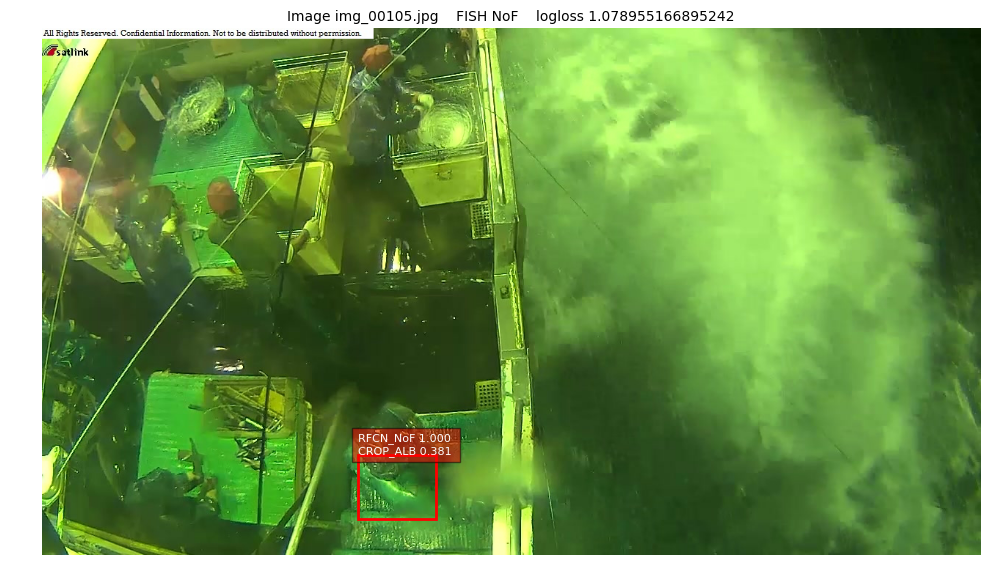

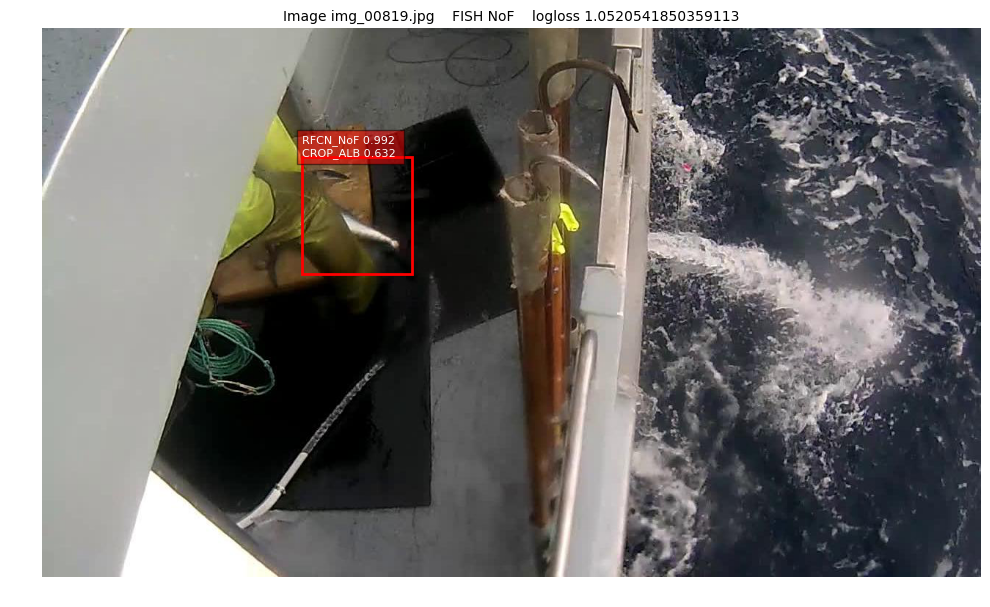

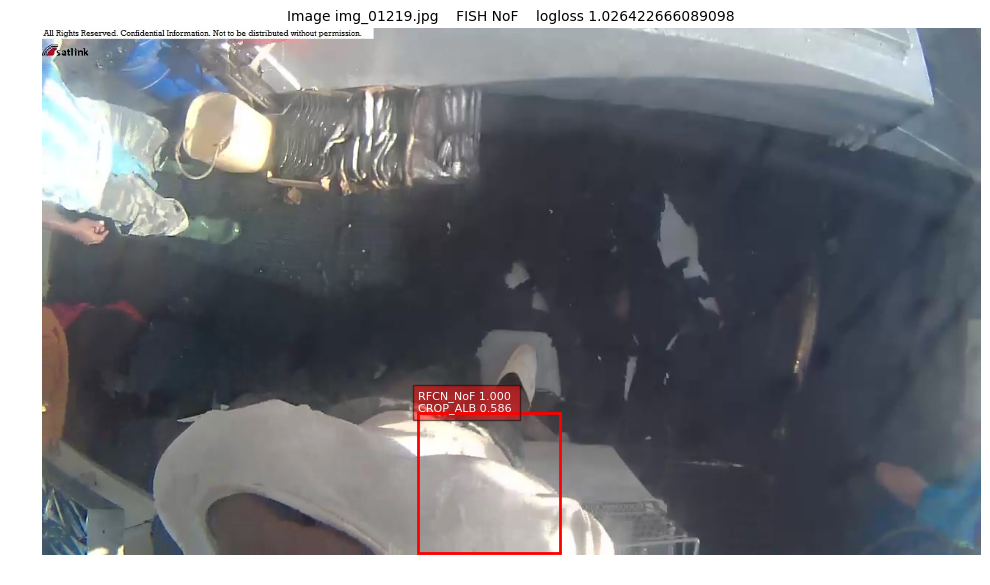

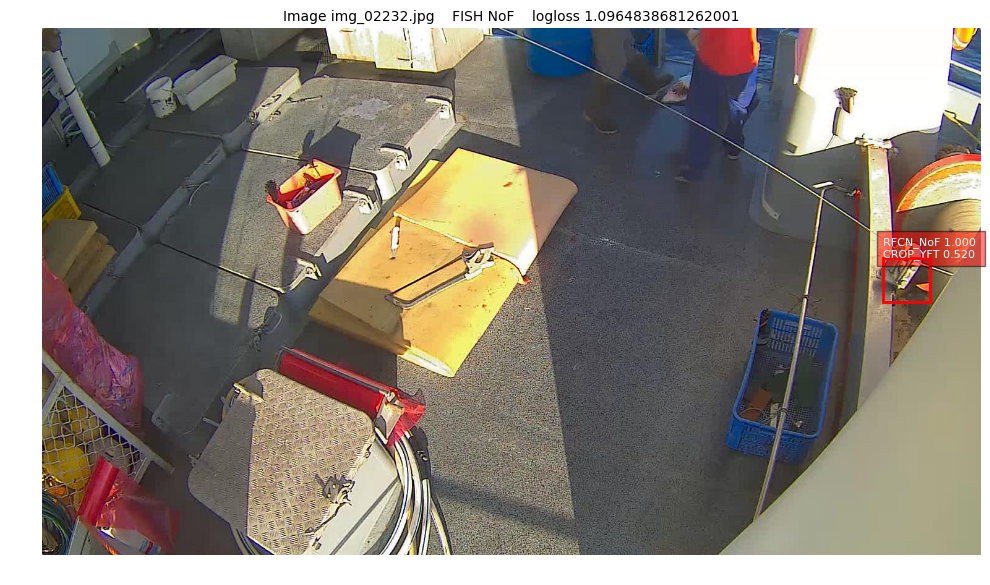

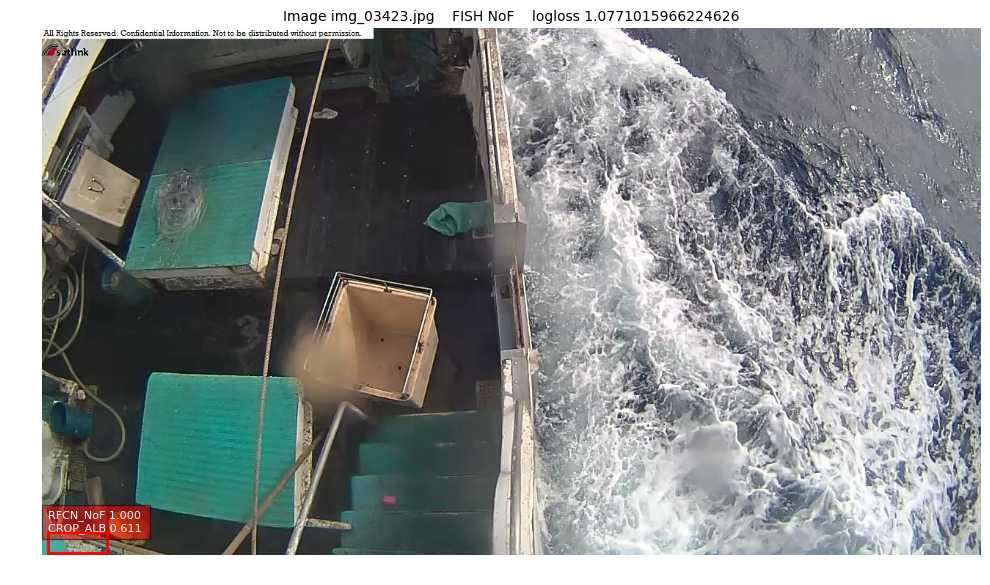

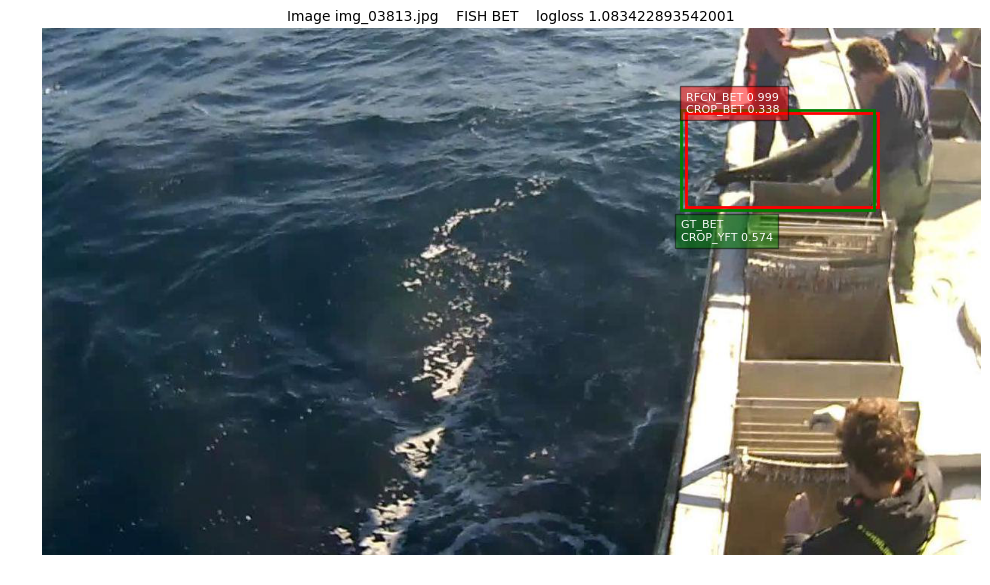

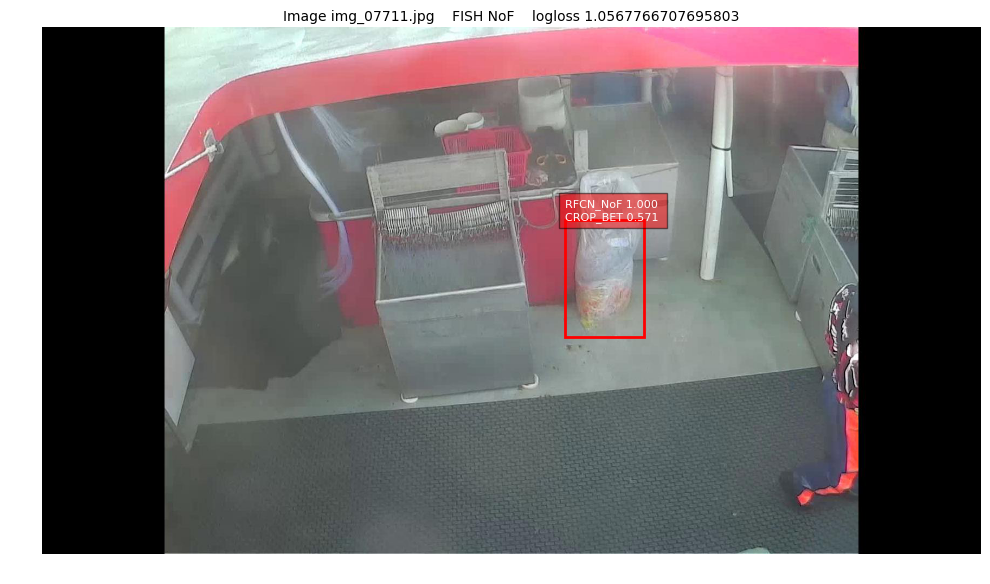

In [25]:
#### visualization
# RFCNbbox_RFCNpred_CROPpred_df = ['image_class', 'image_file','crop_index','x_min','y_min','x_max','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN'
#                                    'NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']
#GTbbox_CROPpred_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#                      'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'logloss']
# test_pred_df = ['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

for j in range(test_pred_df.shape[0]):
    image_logloss = test_pred_df.iat[j,0]
    image_class = test_pred_df.iat[j,1]
    image_file = test_pred_df.iat[j,2]
    if image_logloss > 1 and image_logloss < 1.1:
        im = Image.open('../RFCN/JPEGImages/'+image_file)
        im = np.asarray(im)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(im, aspect='equal')
        RFCN_dets = RFCNbbox_RFCNpred_CROPpred_df.loc[RFCNbbox_RFCNpred_CROPpred_df['image_file']==image_file]
        for index,row in RFCN_dets.iterrows():
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            RFCN = [row['NoF_RFCN'],row['ALB_RFCN'],row['BET_RFCN'],row['DOL_RFCN'],row['LAG_RFCN'],row['OTHER_RFCN'],row['SHARK_RFCN'],row['YFT_RFCN']]
            CROP = [row['NoF_CROP'],row['ALB_CROP'],row['BET_CROP'],row['DOL_RFCN'],row['LAG_CROP'],row['OTHER_CROP'],row['SHARK_CROP'],row['YFT_CROP']]
            score_RFCN = max(RFCN)
            score_CROP = max(CROP)
            index_RFCN = RFCN.index(score_RFCN)
            index_CROP = CROP.index(score_CROP)
            class_RFCN = FISH_CLASSES[index_RFCN]
            class_CROP = FISH_CLASSES[index_CROP]
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='red', linewidth=2))
            ax.text(bbox[0], bbox[1] - 2, 'RFCN_{:s} {:.3f} \nCROP_{:s} {:.3f}'.format(class_RFCN, score_RFCN, class_CROP, score_CROP), bbox=dict(facecolor='red', alpha=0.5), fontsize=8, color='white')       
        GT_dets = GTbbox_CROPpred_df.loc[GTbbox_CROPpred_df['image_file']==image_file]
        for index,row in GT_dets.iterrows():
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            CROP = [row['NoF'],row['ALB'],row['BET'],row['DOL'],row['LAG'],row['OTHER'],row['SHARK'],row['YFT']]
            score_CROP = max(CROP)
            index_CROP = CROP.index(score_CROP)
            class_CROP = FISH_CLASSES[index_CROP]
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='green', linewidth=2))
            ax.text(bbox[0], bbox[3] + 40, 'GT_{:s} \nCROP_{:s} {:.3f}'.format(row[2], class_CROP, score_CROP), bbox=dict(facecolor='green', alpha=0.5), fontsize=8, color='white')
        ax.set_title(('Image {:s}    FISH {:s}    logloss {}').format(image_file, image_class, image_logloss), fontsize=10) 
        plt.axis('off')
        plt.tight_layout()
        plt.draw()

In [26]:
#temperature
T = 1
test_pred_array = test_pred_df[FISH_CLASSES].values
test_pred_T_array = np.exp(np.log(test_pred_array)/T)
test_pred_T_array = test_pred_T_array/np.sum(test_pred_T_array, axis=1, keepdims=True)
test_pred_T_df = pd.DataFrame(test_pred_T_array, columns=FISH_CLASSES)
test_pred_T_df = pd.concat([test_pred_df[['image_class','image_file']],test_pred_T_df], axis=1)

#add logloss
test_pred_T_df['logloss'] = test_pred_T_df.apply(lambda row: -math.log(row[row['image_class']]) if row['image_class']!='--' else np.nan, axis=1)

#calculate train logloss
print(test_pred_T_df.groupby(['image_class'])['logloss'].mean())
train_logloss = test_pred_T_df['logloss'].mean()
print('logloss of train is', train_logloss )

image_class
--            NaN
ALB      0.036760
BET      0.063365
DOL      0.113835
LAG      0.000368
NoF      0.825403
OTHER    0.012940
SHARK    0.148912
YFT      0.026265
Name: logloss, dtype: float64
logloss of train is 0.1383043427231991


In [22]:
#test submission
submission = test_pred_T_df.loc[:999,['image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']]
submission.rename(columns={'image_file':'image'}, inplace=True)
sub_file = 'RFCN_AGONOSTICnms_'+RFCN_MODEL+'_'+CROP_MODEL+'_clsMaxAve_conf{:.2f}_T{}_'.format(CONF_THRESH, T)+'{:.4f}'.format(train_logloss)+'.csv'
submission.to_csv(sub_file, index=False)
print('Done!'+sub_file)

Done!RFCN_AGONOSTICnms_resnet101_rfcn_ohem_iter_30000_resnet50_FT38_DataLessNoF_clsMaxAve_conf0.80_T2.5_0.2659.csv
